<img src="resources/titanic_sinking.gif" alt="Titanic sinking gif" style="margin: 10px auto 20px; border-radius: 15px;" width="100%"/>

<a id="project-overview"></a>
_**Potonuće Titanika** jedno je od najozloglašenijih brodoloma u istoriji._

_15. aprila 1912. godine, tokom njegovog prvog putovanja, široko smatrani „nepotopivi“ RMS Titanic potonuo je nakon sudara sa santom leda u severnom Atlantskom okeanu. Nažalost, nije bilo dovoljno čamaca za spasavanje za sve na brodu, što je rezultovalo smrću 1502 od 2224 putnika i posade._

_Iako je u preživljavanju učestvovao neki element sreće, čini se da su neke grupe ljudi imale veću verovatnoću preživljavanja u odnosu na druge._

Cilj projekta predstavlja prediktivni model koji odgovara na pitanje: _„za koje vrste ljudi je veća verovatnoća da će preživeti?“_ korišćenjem dostupnih podataka o putnicima (tj. ime, starost, pol, socijalno-ekonomska klasa, itd.).

<hr>

<a id="table-of-contents"></a>
### Pregled sadržaja:
* [Pregled projekta](#project-overview)
* [Učitavanje i opis skupa podataka](#loading-datasets)
* [Provera relevantnosti kolona za model](#column-relevance)
* [Kreiranje trening i test skupova podataka](#train-test-split)
* [Evaluacija/bodovanje klasifikacionih algoritama](#model-scoring)
* [Model i predikcija](#model-prediction)

<hr>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC

%matplotlib inline

### Učitavanje i opis skupa podataka <a id="loading-datasets"></a>

<a href="#table-of-contents"> Povratak na pregled sadržaja </a>



<div style="display: inline-block;">

    
| Variable | Definition                               | Key                                            |
|----------|------------------------------------------|------------------------------------------------|
| Survived | Yes or No                                | 1 = Survived, 0 = Died                                         |
| Pclass   | A proxy of socio-economic status (SES)   | 1 = Upper,  2 = Middle, 3 = Lower              |
| Name     | Passenger name                           | e.g. Allen, Mr. William Henry                  |
| Sex      | Passenger sex                            | male or female                                 |
| Age      | Passenger age                            | integer                                        |
| SibSp    | # of siblings/spouses aboard the Titanic | integer                                        |
| Parch    | # of parents/children aboard the Titanic | integer                                        |
| Ticket   | Ticket number                            | e.g. A/5 21171                                 |
| Fare     | Passenger fare                           | float                                          |
| Cabin    | Cabin number (str)                       | e.g. B42                                       |
| Embarked | Port of Embarkation                      | C = Cherbourg, Q = Queenstown, S = Southampton |
    
    
</div>

- **train.csv** sadrži detalje o podskupu putnika na brodu (tačnije 891 putnik - gde svaki putnik predstavlja zaseban red u tabeli).
- **test.csv** sadrži detalje o podskupu putnika na brodu (tačnije 418 putnika - gde svaki putnik predstavlja zaseban red u tabeli) ** **bez 'Survived' kolone**.

In [2]:
# ucitavanje skupova podataka
train_df = pd.read_csv("datasets/train.csv").dropna(subset=["Age"])
test_df = pd.read_csv("datasets/test.csv")

train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,448.582633,0.406162,2.236695,29.699118,0.512605,0.431373,34.694514
std,259.119524,0.491460,0.838250,14.526497,0.929783,0.853289,52.918930
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.250000,0.000000,1.000000,20.125000,0.000000,0.000000,8.050000
50%,445.000000,0.000000,2.000000,28.000000,0.000000,0.000000,15.741700
75%,677.750000,1.000000,3.000000,38.000000,1.000000,1.000000,33.375000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


### Provera relevantnosti kolona za model<a id="column-relevance"></a>

Potrebno je proveriti koje od kolona uticu na rezultat prezivljavanja odredjenog putnika.

- Sex - Izracunavanjem srednje vrednosti smo ustanovili da je **pol** putnika igrao bitnu ulogu u prezivljavanju. (veci deo prezivelih je bio zenskog pola)
- Pclass - Izracunavanjem srednje vrednosti smo ustanovili da je **socijalno-ekonomska klasa** putnika igrala bitnu ulogu u prezivljavanju
- SibSp - Iz histograma mozemo zakljuciti da je vecina prezivelih imala manje od dvoje brace/sestara ili partnera na Titaniku, tako da je **broj brace/sestara/partnera** igrao bitnu ulogu u prezivljavanju.
- Age - Iz histograma mozemo zakljuciti da je vecina prezivelih bila starosti od 20-40 godina.
- Parch - Iz histograma mozemo zakljuciti da je vecina prezivelih imala manje od dva deteta ili roditelja na Titaniku, tako daje **broj dece/roditelja** igrao bitnu ulogu u prezivljavanju. 
- U 'Cabin' koloni postoje duplikati, verovatno zato sto su odredjeni putnici delili kabinu, takodje ima dosta nepotpunih podataka.
- Vecina putnika se ukrcala u Southampton-u.
- Ime putnika kao i identifikacioni broj putnika nemaju nikakav uticaj na prezivljavanje.

<a href="#table-of-contents"> Povratak na pregled sadržaja </a>

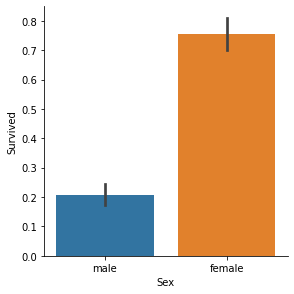

Procenat muskaraca koji su preziveli iznosi 20.53%, a procenat zena 75.48%.



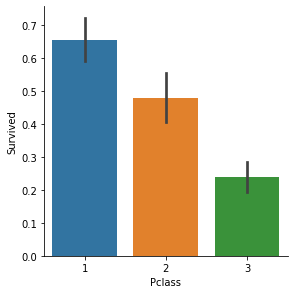

Procenat prezivelih vise socijalno-ekonomske klase iznosi 65.59%, srednje 47.98%, i nize klase 23.94%.



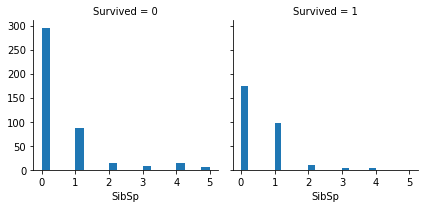

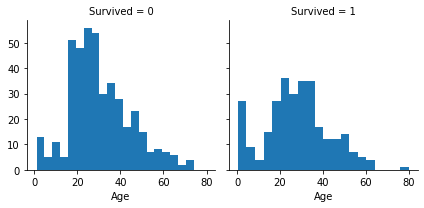

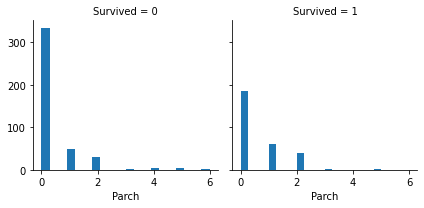

In [3]:
# Sex
sns.catplot(x="Sex", y ="Survived", data=train_df, kind="bar", height=4)
plt.show()

men = np.mean(train_df.loc[train_df.Sex == 'male']["Survived"])
women = np.mean(train_df.loc[train_df.Sex == 'female']["Survived"])

print(f'Procenat muskaraca koji su preziveli iznosi {men * 100:.2f}%, a procenat zena {women * 100:.2f}%.\n')

# Pclass
sns.catplot(x="Pclass", y ="Survived", data=train_df, kind="bar", height=4)
plt.show()

upper = np.mean(train_df.loc[train_df.Pclass == 1]["Survived"])
middle = np.mean(train_df.loc[train_df.Pclass == 2]["Survived"])
lower = np.mean(train_df.loc[train_df.Pclass == 3]["Survived"])

print(f'Procenat prezivelih vise socijalno-ekonomske klase iznosi {upper * 100:.2f}%,',
      f'srednje {middle * 100:.2f}%,',
      f'i nize klase {lower * 100:.2f}%.\n')

# SibSp
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'SibSp', bins=20)
plt.show()

# Age
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)
plt.show()

# Parch
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Parch', bins=20)
plt.show()

### Kreiranje trening i test skupova podataka <a id="train-test-split"></a>

<a href="#table-of-contents"> Povratak na pregled sadržaja </a>

In [4]:
features = ["Pclass", "Sex", "SibSp", "Parch"]

train_x = pd.get_dummies(train_df[features])
train_y = train_df.Survived.to_numpy()

test_x = pd.get_dummies(test_df[features])

### Evaluacija/bodovanje klasifikacionih algoritama <a id="model-scoring"></a>

<a href="#table-of-contents"> Povratak na pregled sadržaja </a>

Bodovanjem 5 klasifikacionih algoritama cemo odrediti koji nam najvise odgovara za kreiranje prediktivnog modela.

Algoritmi koji su bodovani/evaluirani:
- Random Forest ❌
- K Nearest Neighbor (KNN) ❌
- Support Vector Machine (SVM) ✔️
- Logistic Regression ❌
- Perceptron ❌

Evaluaciju smo vrsili sa '**cross_val_score**' metodom koja predstavlja nacin da iskoristimo trening podatke da bismo dobili dobre procene kako ce se model izvrsavati sa test podacima.

In [13]:
"""
Random Forest
"""
random_forest = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=1)
score = cross_val_score(random_forest, train_x, train_y, scoring='accuracy', cv=10).mean()
print(f'Random Forest Score: {score * 100:.2f}%')


"""
KNN
"""
knn = KNeighborsClassifier(n_neighbors=25)
score = cross_val_score(knn, train_x, train_y, scoring='accuracy', cv=10).mean()
print(f'KNN Score: {score * 100:.2f}%')


"""
SVM
"""
svm = SVC(kernel="rbf")
score = cross_val_score(svm, train_x, train_y, scoring='accuracy', cv=10).mean()
print(f'SVM Score: {score * 100:.2f}%')


"""
Logistic Regression
"""
log_reg = LogisticRegression(max_iter=2000)
score = cross_val_score(log_reg, train_x, train_y, scoring='accuracy', cv=10).mean()
print(f'Logistic Regression Score: {score * 100:.2f}%')


"""
Perceptron
"""
perceptron = Perceptron(random_state=1)
score = cross_val_score(perceptron, train_x, train_y, scoring='accuracy', cv=10).mean()
print(f'Perceptron Score: {score * 100:.2f}%')

Random Forest Score: 78.58%
KNN Score: 77.86%
SVM Score: 79.27%
Logistic Regression Score: 78.28%
Perceptron Score: 67.95%


### Model i predikcija  <a id="model-prediction"></a>

<a href="#table-of-contents"> Povratak na pregled sadržaja </a>

S obzirom da smo pri evaluaciji 5 klasifikacionih algoritama videli da **Support Vector Machine** (_SVM_) klasifikator daje najbolje rezultate, njega cemo odabrati za kreiranje prediktivnog modela.

In [6]:
svm.fit(train_x, train_y)
predictions = svm.predict(test_x)

output = pd.DataFrame({'PassengerId': test_df.PassengerId, 'Survived': predictions})
output.to_csv('survival_prediction.csv', index=False)

output

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


### Score

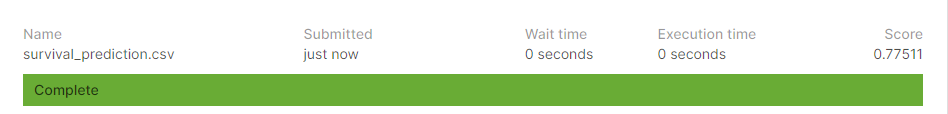